In [1]:
import numpy as np
import numpy.random as rd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import dill
import sys
sys.path.append('../Dan_research/spock')
from spock.modelfitting import train_test_split, ROC_curve, stable_unstable_hist, calibration_plot, unstable_error_fraction
import spock.feature_functions as ff
import rebound

In [89]:
os.system("jupyter nbconvert --to markdown Tutorial.ipynb");

In [74]:
seconds_p_day = 86400
days_p_year = 365.25
meters_p_AU = 149597870700
earth_mass_p_solar_mass = 333000
year_p_reboundtime = 1 / (2 * np.pi)
AU_p_RS = 0.00465047

def replace_snapshot(sim, filename):
    if os.path.isfile(filename):
        os.remove(filename)
    sim.simulationarchive_snapshot(filename)
    
def loguniform(low=0.001, high=1, size=None):
    return np.exp(rd.uniform(np.log(low), np.log(high), size))

def max_e_inner(a_in, a_out, e_out=0):
    return a_out / a_in * (1 - e_out) - 1

def max_e_outer(a_out, a_in, e_in=0):
    return 1 - a_in / a_out * (1 + e_in)

def min_es(ms, As):
    Nplanets = len(ms)
    e_mins = np.zeros(Nplanets)
    for i in range(Nplanets):
        e_mins[i] = As[i] ** 2
        inner_sum = 0
        for j in range(Nplanets):
            if i != j:
                inner_sum += (ms[j] / np.max([As[i], As[j]]) ** 2) ** 2
        e_mins[i] *= np.sqrt(inner_sum)
    return e_mins

def check_es(a0, e0, a1, e1, a2, e2):
    return (e0 <= max_e_inner(a0, a1, e1)) and (e1 <= max_e_inner(a1, a2, e2)) and (e1 <= max_e_outer(a1, a0, e0)) and (e2 <= max_e_outer(a2, a1, e1))

"""
Generating random systems
Using methodolgy similar to Tamayo et al. 2020 (in prep)
"""
# 
def generate_system():
    Mstar = 1
    mutual_hill_radii_sep = rd.uniform(low=0, high=30, 2)
    incs = rd.uniform(1e-3, 1e-1, 3)  # inclinations (radians)
    Ws = 2 * np.pi * rd.rand(3)  # longitude of ascending node (radians)
    ws = 2 * np.pi * rd.rand(3)  # pericenter orientation (radians)
    Ms = 2 * np.pi * rd.rand(3)  # initial orbital phase (radians)
    ms = loguniform(1e-7, 1e-4, 3)  # mass ratios of planets to star, from ~1/3 Mars to ~2x Neptune 
    
    As = np.ones(3)
    As[0] = rd.uniform(low=0.5, high=1.5)  # first planet is 0.5 to 1.5 AU from central star
    for i in range(1,3):  # the other semi major axes are chosen by a mutual radii separation of 0-30
        shared_quant = np.cbrt(9 * (ms[i-1] + ms[i]) / Mstar) * mutual_hill_radii_sep[i-1]
        As[i] = As[i-1] * (6 + shared_quant) / (6 - shared_quant)
        
    es = np.array([0,0,0])
    bad_es = True
    e0_max = max_e_inner(As[0], As[1])
    e1_max = np.minimum(max_e_inner(As[1], As[2], es[2]), max_e_outer(As[1], As[0]))  # ~0.15
    e2_max = max_e_outer(As[2], As[1])
    e_mins = min_es(ms, As)
    while bad_es:
        es = np.array([loguniform(e_mins[0], e0_max), loguniform(e_mins[1], e1_max), loguniform(e_mins[2], e2_max)])
        bad_es = not check_es(As[0], es[0], As[1], es[1], As[2], es[2])

    sim = rebound.Simulation()
    sim.add(m=1.)
#     print(ms, As, es, Ws, ws, Ms, incs)
    for i in range(3):
        sim.add(m=ms[i], a=As[i], e=es[i], Omega=Ws[i], omega=ws[i], M=Ms[i], inc=incs[i])
    sim.move_to_com()
    return sim

In [83]:
sim_names = "test_sims/"
n = 10
sa_names = [("id_%5.0d.bin"%i).replace(" ","0") for i in range(n)]

for i in range(n):
    sim = generate_system()
    replace_snapshot(sim, sim_names + sa_names[i])

In [84]:
Norbits = 10000
Nout = 80
trios = [[i,i+1,i+2] for i in range(1,sim.N_real-2)]
features_args = [Norbits, Nout] + [trios]

df = pd.DataFrame(ff.features(rebound.SimulationArchive(sim_names + sa_names[0])[0], features_args)[0])
for i in range(1,n_small):
    df = df.append(pd.DataFrame(ff.features(rebound.SimulationArchive(sim_names + sa_names[i])[0], features_args)[0]), ignore_index=True)

df["sim"] = sa_names
df

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd,sim
0,0.028118,0.166610,0.000038,NaN,0.846856,0.000077,0.000022,NaN,70.982251,23.754885,id_00000.bin
1,0.011435,NaN,NaN,NaN,0.110439,NaN,NaN,NaN,NaN,NaN,id_00001.bin
2,0.474298,0.007330,0.001356,NaN,0.777283,0.000193,0.000125,NaN,2.048657,0.227476,id_00002.bin
3,0.163710,0.008195,0.001451,0.008253,0.203941,0.000624,0.000034,0.020223,2.031106,0.225543,id_00003.bin
4,0.494556,0.000558,0.000163,NaN,0.537827,0.000508,0.000097,0.006829,2.031509,0.225664,id_00004.bin
5,0.227342,0.016265,0.002741,0.027690,0.419067,0.048081,0.004899,0.010698,139.569970,40.551850,id_00005.bin
6,0.248496,0.001293,0.000474,0.000537,0.376917,0.000833,0.000045,0.000231,2.012844,0.223537,id_00006.bin
7,0.220292,0.050049,0.000365,0.125627,1.064082,0.037364,0.004581,0.128535,22.362868,6.920978,id_00007.bin
8,0.490061,0.000274,0.000021,NaN,0.602438,0.000282,0.000014,0.016440,2.095067,0.232734,id_00008.bin
9,0.312278,0.002191,0.000008,0.074712,0.490182,0.001205,0.000048,NaN,2.165331,0.240415,id_00009.bin


[2.8493147903958467, 3.974830773308586, 6.421992020106921]
([EMcrossnear        0.248496
EMfracstdnear      0.001293
EPstdnear          0.000474
MMRstrengthnear    0.000537
EMcrossfar         0.376917
EMfracstdfar       0.000833
EPstdfar           0.000045
MMRstrengthfar     0.000231
MEGNO              2.012844
MEGNOstd           0.223537
dtype: float64], True)


(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f2da66f8690>)

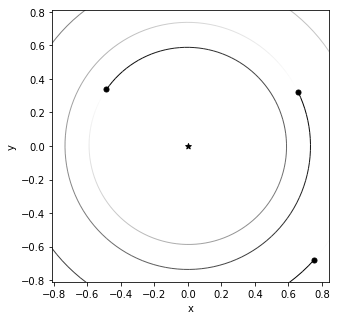

In [85]:
sim = rebound.SimulationArchive(sim_names + sa_names[6])[0]
print([sim.particles[1+i].P for i in range(3)])
print(ff.features(sim, features_args))
rebound.OrbitPlot(sim)

# will work on stuff below tomorrow

In [ ]:
datapath = '../Dan_research/spock/training_data/'
dset = 'resonant/'
Norbits = 1e4
Nout = 80
featureargs = (Norbits, Nout) # params to pass feature function
featurefolder = 'additional_featuresNorbits{0:.1f}Nout{1}trio/'.format(Norbits, Nout)
trainingdatafolder = datapath+dset+featurefolder

In [ ]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 50),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

def objective(params):
    clf = XGBClassifier(n_estimators = 100,
                            max_depth = params['max_depth'], 
                            min_child_weight = params['min_child_weight'],
                            subsample = params['subsample'],
                            colsample_bytree = params['colsample_bytree'],
                            learning_rate = params['learning_rate'], seed = 0)
    
    score = xgb.cv(clf.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    print("SCORE:", avg_score, "ERROR", error)#, "HOLDOUT SCORE", test_score)
    return{'loss':1-avg_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error}

In [ ]:
trainingdatafolder

In [ ]:
features = ['MEGNO']

trainX, trainY, testX, testY = train_test_split(trainingdatafolder, features, filter=False)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

In [ ]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials, rstate=np.random.RandomState(seed=0))
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

In [ ]:
best

In [ ]:
model = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

score = xgb.cv(model.get_xgb_params(), dtrain, nfold = 5, metrics = "auc", verbose_eval=True, num_boost_round=10)
model.fit(trainX, trainY)

In [ ]:
model.save_model(datapath+'../models/megno.bin')
dill.dump([model, features, featureargs, featurefolder], open(datapath+"../models/megno.pkl", "wb"))

In [ ]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(trainingdatafolder, model, features)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [ ]:
model, features, featureargs, featurefolder = dill.load(open('../models/megno.pkl', 'rb'))

In [ ]:
for i in range(0,len(tpr), 15):
    print("Threshold {0}, TPR = {1}, FPR = {2}".format(ROCthresholds[i], tpr[i], fpr[i]))